In [1]:
import sys
sys.path.insert(0, '../src')

from megs.model.mPCA import mPCA
from megs.data import image, DataLoader, Galaxy

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

import numpy as np
import pickle
from tqdm import trange
import seaborn as sns
sns.set_context("paper", font_scale=1.5)

# Load mm object from the file
#filename = "morphmodel.pkl"
#filename = "2dmorphmodel400.pkl"
#with open(filename, "rb") as file:


#    mm = pickle.load(file)

In [2]:
data = DataLoader("/export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5", m_min = 8)


File: /export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5
Group: Galaxies
    Group: Attributes
        Dataset: halo_id (float32) ((12484,))
        Dataset: mass (float32) ((12484,))
    Group: Particles
        Group: stars
            Group: Images
                Group: dim2
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64))
                Group: dim3
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64, 64))


In [3]:
norm = image.norm # Normalization function
lower = 0.25
upper = 1.0
norm_function_args = {"Masses": {"takelog": True, "plusone": True,"lower": lower, "upper": upper},
                     "GFM_Metallicity": {"takelog": True, "plusone": True, "lower": 0.25, "upper": upper},
                     "GFM_StellarFormationTime": {"takelog": True, "plusone": True, "lower": 0.25, "upper": upper},
                    
}



In [4]:
mm = mPCA(data, norm_function = norm, norm_function_kwargs=norm_function_args, dim = 2)

Creating datamatrix with the following fields:
Particle type:  stars
Fields:  ['GFM_Metallicity', 'GFM_StellarFormationTime', 'Masses']
Dimension:  dim2
Default arguments are used for the fields that are not specified in the norm_function_kwargs
Created datamatrix with shape:  (12484, 12288)


In [5]:
mm.fit(n_components = 512, show_results = False)

In [6]:
original = mm.get_images()
eigengalaxies = mm.get_eigengalaxies()
means = mm.get_means()
scores = mm.get_scores()

In [8]:
def reconstruct(galindex, col, original=original, scores=scores, eigen=eigengalaxies, means=means, plot=True, cmap=None, 
                savepath = None, show = True, labelsize=20,w_pad = 0.1,h_pad = 0.1, text_coords=(-32,32), start_index = 1):
    og = original[galindex]
    

    # Calculate the range for the residue images
    
    fields = ["Metallicity", "Stellar Age", "Masses"]
    if cmap is None:
        cmap = {"Metallicity": "magma", "Stellar Age": "gist_heat", "Masses": "cividis"}
    ncomp = start_index
    col = int(col)+1
    figsize = (len(fields)*5+7, col*5)
    if plot:
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(col, len(fields)+1, wspace=0, hspace=0)  # Adjust width ratios to accommodate the colorbar

        for i in range(col):
            
            ax1 = fig.add_subplot(gs[i, 0])
            ax2 = fig.add_subplot(gs[i, 1])
            ax3 = fig.add_subplot(gs[i, 2])
            if i==0:
                ax1.set_title(fields[0],fontsize=labelsize)
                ax2.set_title(fields[1], fontsize=labelsize)
                ax3.set_title(fields[2], fontsize=labelsize)
            if i == col-1:
                ax1.text(*text_coords, "Original", fontsize=labelsize, verticalalignment='center', horizontalalignment='left')
                im = ax1.imshow(og[0], cmap=cmap[fields[0]], vmin=0, vmax=1)
                ax2.imshow(og[1], cmap=cmap[fields[1]])
                ax3.imshow(og[2], cmap=cmap[fields[2]])
            else:
                score = scores[galindex][:ncomp]
                eig = eigen[:ncomp]
                eig = eig.reshape(ncomp, len(fields) * og.shape[1] ** 2)
                means = means.reshape(-1)
                reconstructed = np.dot(score, eig) + means
                reconstructed = reconstructed.reshape(len(fields), 64, 64)
                #residue = og - reconstructed.reshape(len(fields), 64, 64)
                [ax.imshow(reconstructed[i], cmap=cmap[fields[i]]) for i,ax in enumerate([ax1,ax2,ax3])]
                ax1.text(*text_coords, f"n={ncomp}", fontsize=labelsize, verticalalignment='center', horizontalalignment='left')
                ncomp = ncomp * 2
            [ax.axis("off") for ax in [ax1,ax2,ax3]]
          
      
                
        # Add a single colorbar on the right side
       # cax = fig.add_subplot(gs[:, 3])
       # cbar = plt.colorbar(im, cax=cax)
        #cbar.ax.tick_params(labelsize=10)
        #cbar.set_label(, fontsize=labelsize)

        plt.tight_layout(w_pad = w_pad, h_pad =h_pad)
 

        if savepath is not None:
            plt.savefig(savepath, dpi=300, bbox_inches='tight')
        if show: plt.show()

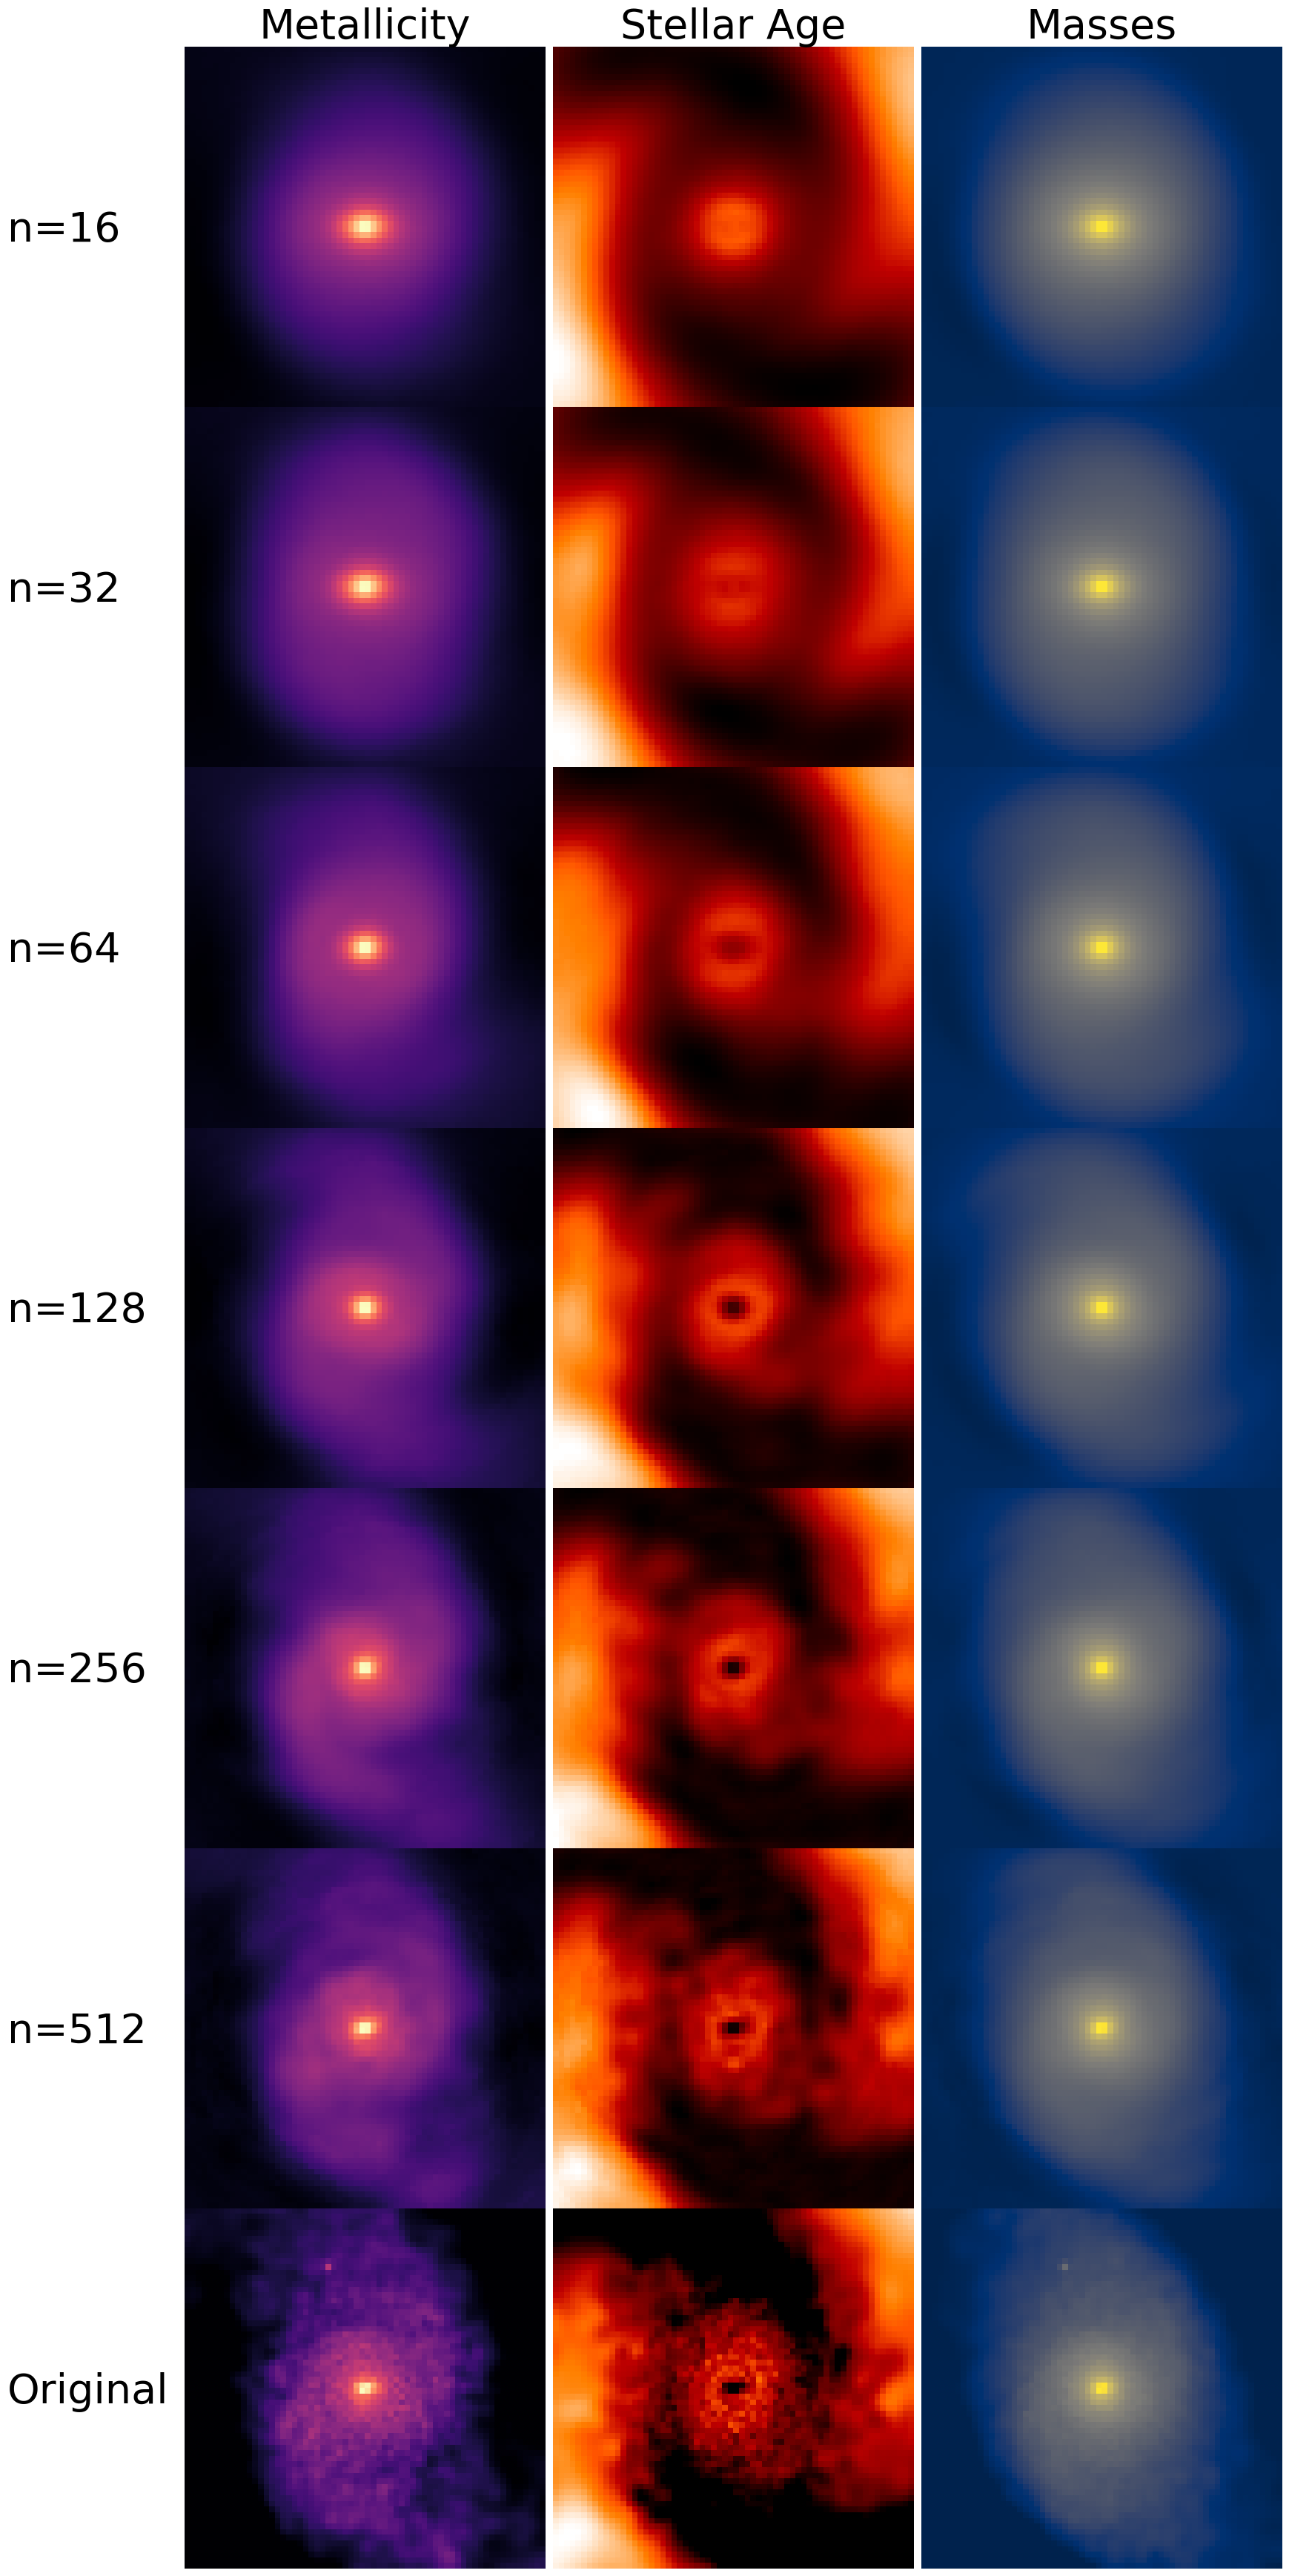

In [9]:
eigencomp = 512
reconstruct(10, col = 6,start_index = 16, plot=True, savepath=f"plots/new_reconstruction_10_{eigencomp}_comp.pdf",w_pad=0.0,h_pad=0, text_coords = (-32,32), labelsize=40)